In [1]:
from skimage import io, color, exposure, img_as_float, measure
from skimage.draw import polygon
from skimage.color import label2rgb
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import h5py
import xarray
import os

In [2]:
img_dir = '/media/gambino/students_workdir/ilias/colonCancerPatient2_tiles/cellbound1/'
tiles = [f'mosaic_Cellbound1_z3_tile{i}.tif' for i in range(1,136)]
tiled_imgs = [io.imread(os.path.join(img_dir,tile)) for tile in tiles]

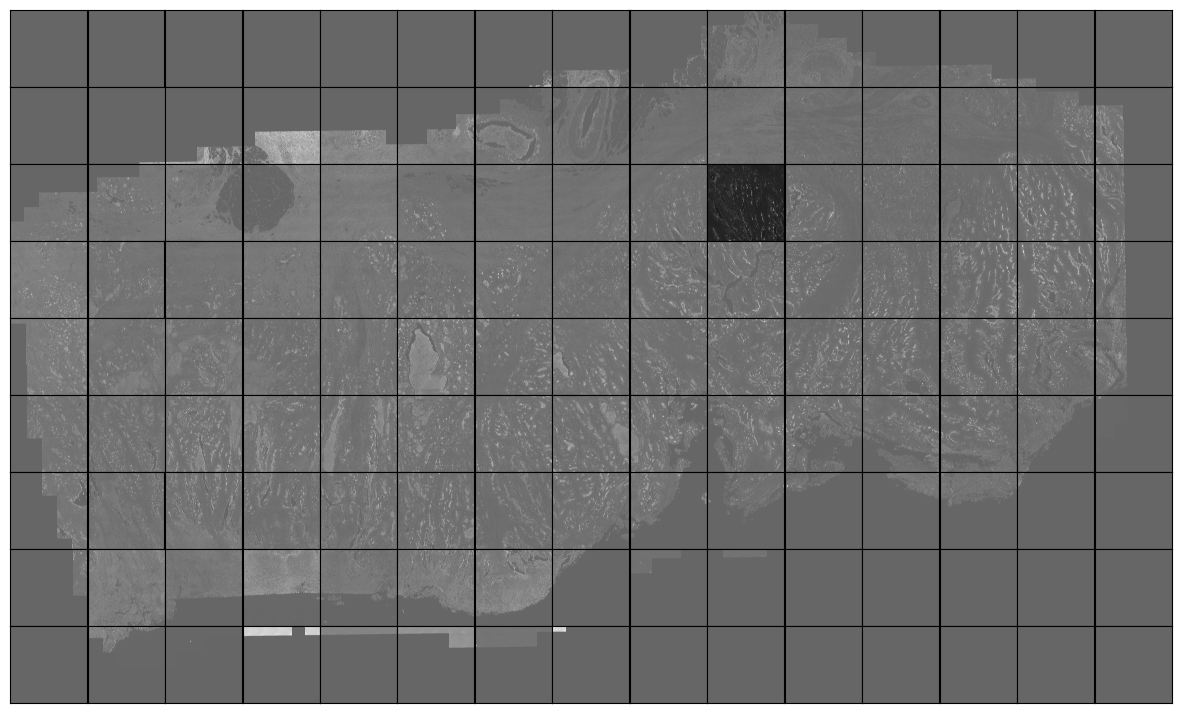

In [5]:
fig,axs = plt.subplots(9,15,sharex=True,sharey=True)
i=0
for img,ax in zip(tiled_imgs,axs.flatten()):
    if i==39:
        ax.imshow(img, cmap = 'gray',alpha=0.9)
    else:
        ax.imshow(img, cmap = 'gray',alpha=0.6)
    ax.set_xticks([])
    ax.set_yticks([])
    i+=1

fig.set_size_inches(15,9)
plt.subplots_adjust(wspace=0, hspace=0)

In [14]:
# tile40 imgs
path = '/media/gambino/students_workdir/ilias/data/images/tile40/'
cellbound_selection = (2,3) # among cellbound1, cellbound2, cellbound3

cellbounds = {f'mosaic_Cellbound{cellbound_selection}_z{z_stack}_tile40.tif': np.array([io.imread(path+f'mosaic_Cellbound{i}_z{z_stack}_tile40.tif') for i in cellbound_selection]) for z_stack in range(7)}
dapi = {f'mosaic_DAPI_z{z_stack}_tile40.tif': io.imread(path+f'mosaic_DAPI_z{z_stack}_tile40.tif') for z_stack in range(7)}
avg_intens_cellbounds = {}
for key in cellbounds.keys():
    avg_intens_cellbounds[key] = np.round(np.average(cellbounds[key], axis=0)).astype(np.uint16)

imgs = [np.dstack((dapi[dapi_key], avg_intens_cellbounds[cellbound_key])) for dapi_key, cellbound_key in zip(dapi.keys(), avg_intens_cellbounds.keys())]

In [ ]:
path = '/media/amenra/MERSCOPE_FFPE/HumanColonCancerPatient2/cell_boundaries/'
data_dict = {}

for file in os.listdir(path):
    with h5py.File(f'{path}/{file}', "r") as f:

        data = f.get('featuredata')

        # get first object name/key; may or may NOT be a group
        group_keys = list(data.keys())

        for key in group_keys:
            data_dict[key] = data[f'{key}/zIndex_3/p_0/coordinates'][...].squeeze()

In [17]:
path = '/media/amenra/MERSCOPE_FFPE/HumanColonCancerPatient2/cell_boundaries/'
data_dict = {}
max_x,max_y = -np.inf, -np.inf
min_x, min_y = np.inf, np.inf
for file in os.listdir(path):
    with h5py.File(f'/media/amenra/MERSCOPE_FFPE/HumanColonCancerPatient2/cell_boundaries/{file}', "r") as f:
        # Print all root level object names (aka keys) 
        # these can be group or dataset names 

        data = f.get('featuredata')

        # get first object name/key; may or may NOT be a group
        group_keys = list(data.keys())

        for key in group_keys:
            data_dict[key] = data[f'{key}/zIndex_3/p_0/coordinates'][...].squeeze()
            if data_dict[key][:,0].max()>= max_x:
                max_x = data_dict[key][:,0].max()
            if data_dict[key][:,0].min()<= min_x:
                min_x = data_dict[key][:,0].min()

            if data_dict[key][:,1].max()>= max_y:
                max_y = data_dict[key][:,1].max()
            if data_dict[key][:,1].min()<= min_y:
                min_y = data_dict[key][:,1].min()

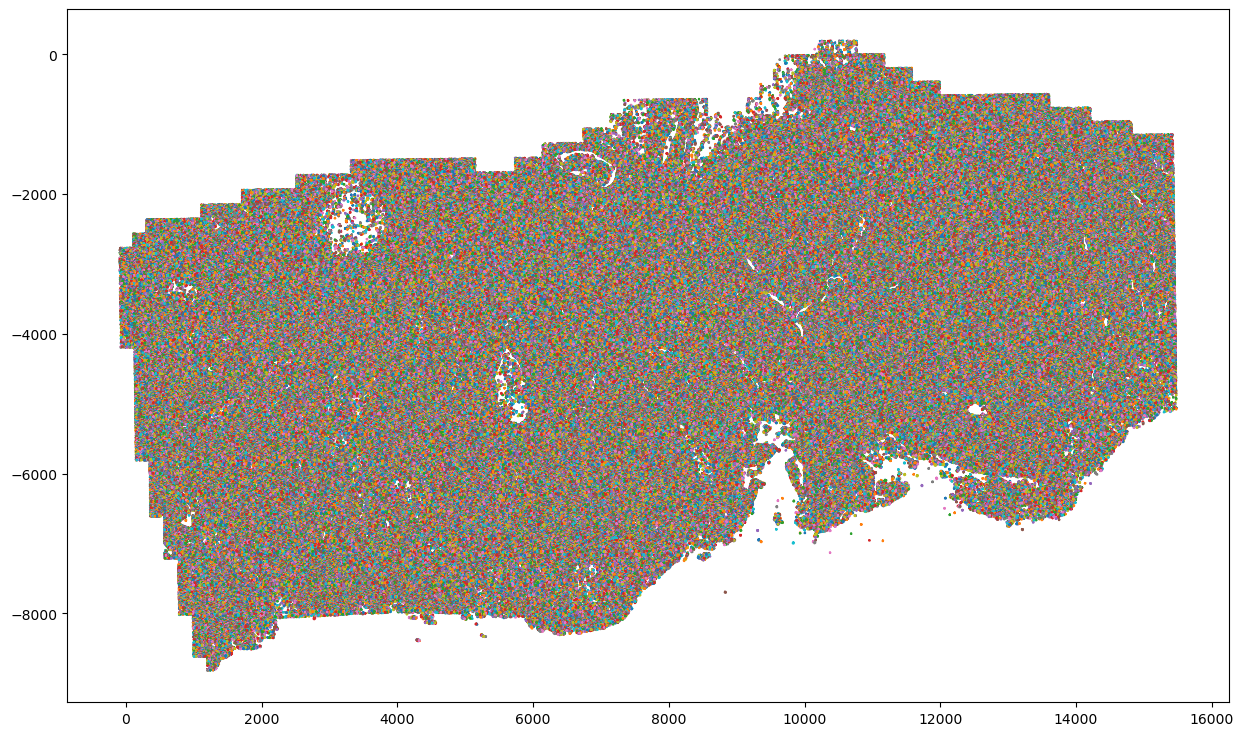

In [21]:
fig,ax = plt.subplots()
fig.set_size_inches(15,9)
for cell in data_dict:
    ax.plot(data_dict[cell][:,0],-data_dict[cell][:,1])
plt.show()

In [18]:
tile40_dict = {'z0':{}, 'z1':{}, 'z2': {}, 'z3':{}, 'z4':{}, 'z5': {}, 'z6':{}}
for z_stack in range(7):
    for file in os.listdir(path):
        with h5py.File(f'/media/amenra/MERSCOPE_FFPE/HumanColonCancerPatient2/cell_boundaries/{file}', "r") as f:
            # Print all root level object names (aka keys) 
            # these can be group or dataset names 

            data = f.get('featuredata')

            # get first object name/key; may or may NOT be a group
            group_keys = list(data.keys())

            for key in group_keys:
                coords = data[f'{key}/zIndex_{z_stack}/p_0/coordinates'][...].squeeze()

                if  (coords[:,0] >= 8500).any() and (coords[:,0] <=11500).any()\
                    and (coords[:,1] >= 1500).any() and (coords[:,1] <= 3500).any():
                    tile40_dict[f'z{z_stack}'][key] = coords

len(tile40_dict)

7

In [11]:
def translate(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = (value - leftMin) / leftSpan

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [22]:
ground_truth_masks = np.zeros((7,10000,10000),dtype=np.int32)
#Couldn't find a better way to align the two scales
# img ranges (0,143690) x (0, 83522)
# coord ranges (-91.57339527621278, 15480.411799063268) x (-195.5093290946811, 8823.037154683212)

range_x = translate(89650, 0, 143690, min_x, max_x), translate(99650, 0, 143690,min_x, max_x,)
range_y = translate(19990, 0, 83522, min_y, max_y), translate(29990, 0, 83522, min_y, max_y)

for z_stack in range(7):
    for cell in tile40_dict[f'z{z_stack}']:
        coords = np.round(tile40_dict[f'z{z_stack}'][f'{cell}']).astype(np.uint32)
        if (coords[:,0] >= range_x[0]).all() and (coords[:,0] < range_x[1]).all()\
            and (coords[:,1] >= range_y[0]).all() and (coords[:,1] < range_y[1]).all():

            coords[:,0] = translate(coords[:,0], range_x[0], range_x[1],0,10000)
            coords[:,1] = translate(coords[:,1], range_y[0], range_y[1],0,10000)

            rr,cc = polygon(coords[:,1],coords[:,0])
            ground_truth_masks[z_stack,rr,cc] = cell

In [23]:
rescaled_img = img_as_float(exposure.rescale_intensity(imgs[3]))
rgb_image = color.gray2rgb(rescaled_img)
merged_image = rgb_image[:,:,1]*[0,1,0] + rgb_image[:,:,0]*[0,0,1]

In [152]:
out_file = '/media/gambino/students_workdir/ilias/colonCancerPatient2_tiles/gt_masks'
dataset = xarray.Dataset(data_vars = dict(images = (['z','row','col','channels'],imgs),
                                        masks = (['z','row','col'], ground_truth_masks)),
                         attrs = dict(dir_path = path, files=[f'({dapi_key},{cellbound_key})' for dapi_key, cellbound_key in zip(dapi.keys(), avg_intens_cellbounds.keys())]))
dataset.to_netcdf(os.path.join(out_file,'tile40.nc'), engine='netcdf4')